# Create fake data to test ability to generate the original distribution

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma
from scipy.interpolate import interp1d

from numpy.random import default_rng
rng = default_rng()

In [2]:
# Load the MAGICC data
magic_path = Path("../data/magic_tprime_sh_land.csv")
magicc_df = pd.read_csv(magic_path)
#magicc_df

In [3]:
def date_to_float(date):
    return ((date - np.datetime64("2000-01-01T00")) / np.timedelta64(1,"D")).astype(float)

dates = np.array(magicc_df["date"].to_numpy(), dtype=np.datetime64)
dates_as_floats = date_to_float(dates)
t_primes = magicc_df["ssp245"].to_numpy()
date_as_float_to_tprime_sh_land = interp1d(
    x = dates_as_floats,
    y = t_primes
)

def date_to_tprime_sh_land(date):
    return date_as_float_to_tprime_sh_land(date_to_float(date))

<AxesSubplot:>

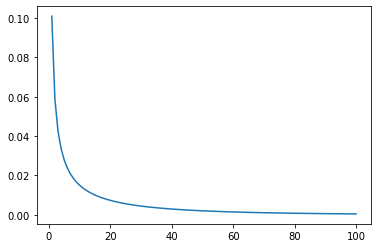

In [4]:
# Let's model precipitation with a gamma
quantiles = np.linspace(0,100, num=100)
shape=0.25
scale=50
ys = gamma.pdf(quantiles, shape, scale=scale)

sns.lineplot(x=quantiles, y=ys)

In [5]:
days_to_simulate = 120 * 365

dates = np.arange(
    start = np.datetime64("1900-01-01"),
    stop = np.datetime64("1900-01-01") + days_to_simulate*np.timedelta64(1,"D"),
    step = np.timedelta64(1,"D")
)

In [6]:
t_primes = date_to_tprime_sh_land(dates)
assert len(t_primes) == len(dates)

In [7]:
# We'll also set the rate of increase in precipitation at a constant 5% per K, not dependent on the quantile
rate = 0.10
def generate_precipitation(t_prime):
    precip = gamma.rvs(shape, scale=scale)
    precip = precip * np.exp(rate*t_prime)
    return precip

In [8]:
precips = np.array([generate_precipitation(t_prime) for t_prime in t_primes])
assert len(precips) == len(dates)

# Add noise
precips += rng.normal(size=len(precips))
precips[precips<0] = 0

# Round to 0.1 mm/day
precips = np.round(precips, 1)
#precips = precips[precips!=0]

In [9]:
# Save out data for Leroy's code to use as input
df = pd.DataFrame({
    "date": dates,
    "t_prime": t_primes,
    "precip": precips
})

df.to_csv(f"simulated_precip__gamma_a_{shape}_scale_{scale}.csv")
df

,date,t_prime,precip
0,1900-01-01,0.259659,39.0
1,1900-01-02,0.259667,0.6
2,1900-01-03,0.259676,3.7
3,1900-01-04,0.259684,5.1
4,1900-01-05,0.259693,0.6
...,...,...,...
43795,2019-11-28,1.588294,3.1
43796,2019-11-29,1.588370,0.0
43797,2019-11-30,1.588446,0.0
43798,2019-12-01,1.588523,2.8


## Attempt to fit the results using Scipy

In [10]:
# Filter precipitation that's too small to measure
threshold = 0.5
mask = precips > threshold
precips = precips[mask]

# Shift precips, so that Gamma doesn't have to worry about 0 to threshold
precips -= threshold

<AxesSubplot:ylabel='Density'>

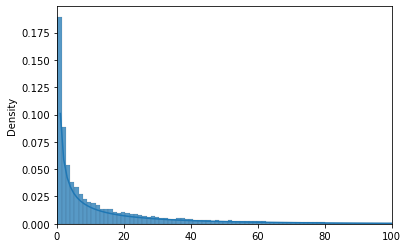

In [11]:
ax=sns.histplot(precips, stat="density")
ax.set_xlim(0,100)

quantiles = np.linspace(0,100, num=100)
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys)

In [12]:
# Can we get the distribution's parameters from the data?
fit_alpha, fit_loc, fit_beta=gamma.fit(precips, floc=0)
print(fit_alpha, fit_loc, fit_beta)

0.5191218481613646 0 34.92623512957952


<AxesSubplot:>

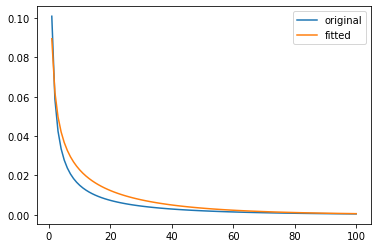

In [13]:
quantiles = np.linspace(0,100, num=100)
ys = gamma.pdf(quantiles, shape, scale=scale)
sns.lineplot(x=quantiles, y=ys, label="original")

ys2 = gamma.pdf(quantiles, fit_alpha, loc=fit_loc, scale=fit_beta)
sns.lineplot(x=quantiles, y=ys2, label="fitted")